
This Notebook will
+ Query video-game articles and associated genre from Wikipedia
+ Select genres with more than a chosen amount of instances
+ Extract monthly count-views for each genre, via the Wikipedia API
+ Save the obtained data in the file `video_game_genre2020`
+ Plot values


In [127]:
#useful imports
from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd
import wikipediaapi
from urllib.request import urlopen
import json
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
sparql = SPARQLWrapper("https://query.wikidata.org/sparql")

Let's extract all video-games as well as their genre from Wikipedia

In [32]:
sparql.setQuery("""
    PREFIX bd: <http://www.bigdata.com/rdf#>
    PREFIX wd: <http://www.wikidata.org/entity/>
    PREFIX wdt: <http://www.wikidata.org/prop/direct/>
    PREFIX wikibase: <http://wikiba.se/ontology#>

select  ?objet ?objectLabel ?genreLabel ?url
where {
    ?object wdt:P31 wd:Q7889.
    ?object wdt:P136 ?genre.

    SERVICE wikibase:label {
      bd:serviceParam wikibase:language "en" .
    }
}
""")
sparql.setReturnFormat(JSON)
games_result = sparql.query().convert()

In [33]:
game_genre_df = pd.json_normalize(games_result['results']['bindings'])
game_genre_df

,objectLabel.xml:lang,objectLabel.type,objectLabel.value,genreLabel.xml:lang,genreLabel.type,genreLabel.value
0,en,literal,Lego Star Wars: The Complete Saga,en,literal,action-adventure game
1,en,literal,Lego Star Wars: The Video Game,en,literal,action-adventure game
2,en,literal,Star Wars Episode I: Racer,en,literal,racing video game
3,en,literal,Star Wars: Bounty Hunter,en,literal,action game
4,en,literal,Star Wars: Racer Arcade,en,literal,racing video game
...,...,...,...,...,...,...
48488,en,literal,Insurgence - Chains of Renegade,en,literal,indie game
48489,en,literal,En-Train,en,literal,indie game
48490,en,literal,Fantasy Fishing Town,en,literal,indie game
48491,en,literal,Rocco's Island: Ring to End the Pain,en,literal,indie game


If we count the number of unique genres, we can see there is a lot

In [34]:
unique_game_genre_df = game_genre_df['genreLabel.value'].unique()
unique_game_genre_df

array(['action-adventure game', 'racing video game', 'action game',
       'platform game', 'strategy video game', 'puzzle video game',
       "shoot 'em up", 'making-of', 'shooter game', 'real-time strategy',
       'fighting game', 'adventure game',
       'massively multiplayer online role-playing game',
       'role-playing video game', 'science fiction video game',
       'first-person shooter', 'third-person shooter',
       'space combat simulation game', 'arcade-style video game',
       'sports video game', 'bowling video game',
       'military education and training', '3D computer graphics software',
       'game creation system', 'vehicular combat game',
       'boxing video game', 'maze video game', 'stealth game',
       'side-scrolling video game', 'scrolling shooter',
       'simulation video game', 'Metroidvania', 'interactive fiction',
       'space flight simulation game', 'space trading and combat game',
       'video game with LGBT character', 'fishing video game',

We will consider here that categories with less than 1000 games are not relevant

In [128]:
test = game_genre_df.groupby(['genreLabel.value'])['objectLabel.value'].count()
irr = test[test.values<1000].index
test

genreLabel.value
action-adventure_game         1765
action_game                   3162
adventure_game                2054
first-person_shooter          1331
indie_game                    4650
platform_game                 2105
puzzle_video_game             2148
racing_video_game             1813
role-playing_video_game       2125
science_fiction_video_game    1306
shoot_'em_up                  1339
sports_video_game             1157
visual_novel                  1621
Name: objectLabel.value, dtype: int64

Once the genres are chosen, we format the article names to enable the research later on

In [36]:
game_genre_df = game_genre_df.drop(game_genre_df[game_genre_df['genreLabel.value'].isin(irr)].index)
game_genre_df = game_genre_df.replace(' – ', '', regex=True)
game_genre_df = game_genre_df.replace('°', '', regex=True)
game_genre_df = game_genre_df.replace(' ', '_', regex=True)
game_genre_df = game_genre_df.replace('/', '_', regex=True)

In [37]:
unique_game_genre_df = game_genre_df['genreLabel.value'].unique()
unique_game_genre_df

array(['action-adventure_game', 'racing_video_game', 'action_game',
       'platform_game', 'puzzle_video_game', "shoot_'em_up",
       'adventure_game', 'role-playing_video_game',
       'science_fiction_video_game', 'first-person_shooter',
       'sports_video_game', 'visual_novel', 'indie_game'], dtype=object)

We can now extract the monthly count-views

In [130]:
def get_monthly_count(code, name, start_date,end_date):
    '''
    Will return a dataframe of the monthly count-views of an article for the period given and a chosen language
    '''

    url = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/{}.wikipedia/all-access/all-agents/{}/monthly/{}/{}'.format(code,name,start_date,end_date)
    response = urlopen(url)
    data_json = json.loads(response.read())
    df =  pd.json_normalize(data_json['items'])
    return df


Here is an example to extract for the action genre

In [39]:
names = game_genre_df[game_genre_df['genreLabel.value']==unique_game_genre_df[0]]['objectLabel.value']


monthly_views_action = np.zeros(12)
for n in names:
    try:
        df = get_monthly_count('en',n,'2020010100','2020123100')
        df=df.replace(np.nan, 0)
        views = (df.views).array
        monthly_views_action+=views
    except:
        pass


In [40]:

df_action = get_monthly_count('en','Hitman:_Blood_Money','2020010100','2020123100')
df_action.views = monthly_views_action
df_action.article = 'action_games'
df_action

,project,article,granularity,timestamp,access,agent,views
0,en.wikipedia,action_games,monthly,2020010100,all-access,all-agents,21078114.0
1,en.wikipedia,action_games,monthly,2020020100,all-access,all-agents,18190467.0
2,en.wikipedia,action_games,monthly,2020030100,all-access,all-agents,24009542.0
3,en.wikipedia,action_games,monthly,2020040100,all-access,all-agents,28754029.0
4,en.wikipedia,action_games,monthly,2020050100,all-access,all-agents,29192451.0
5,en.wikipedia,action_games,monthly,2020060100,all-access,all-agents,26822765.0
6,en.wikipedia,action_games,monthly,2020070100,all-access,all-agents,26035729.0
7,en.wikipedia,action_games,monthly,2020080100,all-access,all-agents,22778476.0
8,en.wikipedia,action_games,monthly,2020090100,all-access,all-agents,20582483.0
9,en.wikipedia,action_games,monthly,2020100100,all-access,all-agents,21983331.0


In [74]:
dates = df_action.timestamp.tolist()
date = []
for d in dates:
    date.append(datetime.strptime(d, '%Y%m%d%H').strftime('%d/%m/%Y'))
date

['01/01/2020',
 '01/02/2020',
 '01/03/2020',
 '01/04/2020',
 '01/05/2020',
 '01/06/2020',
 '01/07/2020',
 '01/08/2020',
 '01/09/2020',
 '01/10/2020',
 '01/11/2020',
 '01/12/2020']

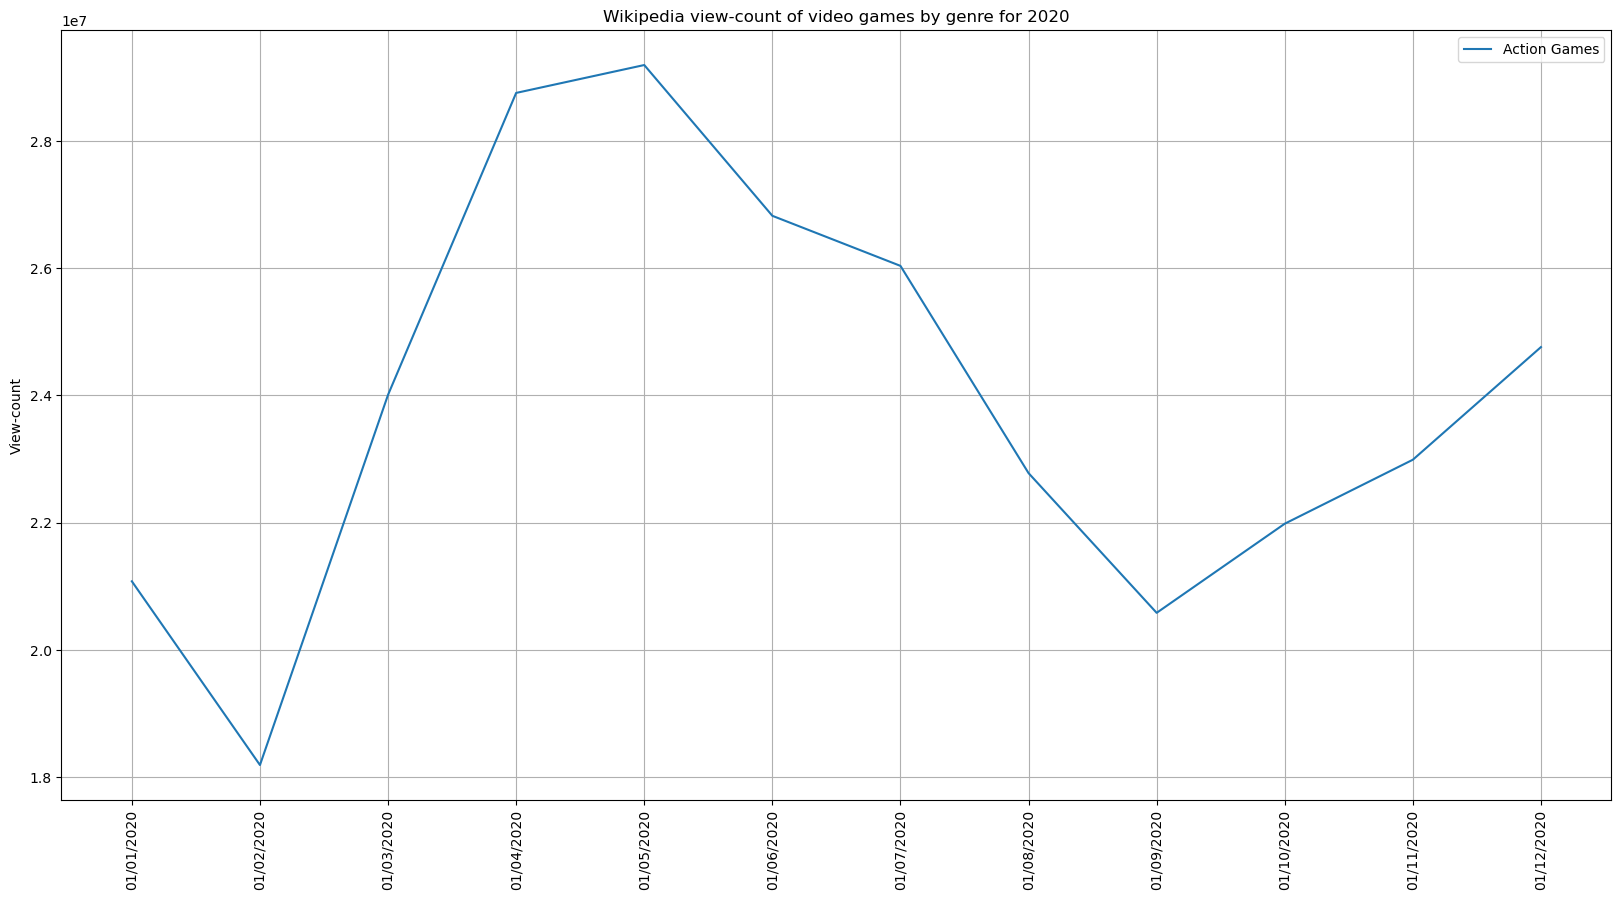

In [76]:
plt.figure(figsize=(20,10))
plt.plot(dates, df_action.views, label="Action Games")
plt.tick_params(axis='x', labelrotation=90)
plt.legend()
plt.grid()
plt.title("Wikipedia view-count of video games by genre for 2020")
plt.ylabel("View-count")
plt.xticks(dates, date)
plt.show()

Now let's compute it for all genres

In [113]:
monthly_views = np.zeros([12,1])

for g in range(len(unique_game_genre_df)):
    names = game_genre_df[game_genre_df['genreLabel.value']==unique_game_genre_df[g]]['objectLabel.value']
    monthly_views_genre = np.zeros([12,1])
    for n in names:
        try:
            df = get_monthly_count('en',n,'2020010100','2020123100')
            df=df.replace(np.nan, 0)
            views = (df.views).array
            views = np.reshape(views,[12,1])
            monthly_views_genre+=views
        except:
            pass
    monthly_views= np.append(monthly_views,monthly_views_genre,axis=1)


In [116]:
final = monthly_views[:,1:]
final

array([[21078112.,  3833782., 15776816., 12823771.,  6020084.,  6216997.,
         9603059.,  8285176.,  7232328.,  8470426.,  2637285.,  1716803.,
         8174650.],
       [18190465.,  3421738., 13500198., 10997641.,  5130817.,  5224861.,
         7967089.,  7316372.,  6275402.,  7967675.,  2615409.,  1508233.,
         7294164.],
       [24009540.,  3995808., 15503313., 12918494.,  5725841.,  6277233.,
         8987768.,  8620368.,  7656922., 12020184.,  2487448.,  1649490.,
         8463341.],
       [28754027.,  5080050., 18867462., 14938802.,  6800182.,  7095543.,
        10881668., 12486837., 10079612., 12347584.,  2580062.,  2003494.,
         9597789.],
       [29192449.,  4878953., 19012650., 14803330.,  6341135.,  6954233.,
        10238870.,  9989282.,  8761926., 10715658.,  2803942.,  1979320.,
         8794859.],
       [26822763.,  4366440., 18601378., 13585118.,  5710849.,  5801535.,
         8750638.,  8197269.,  7826553.,  9596858.,  2173187.,  1749472.,
         789

In [121]:
df = pd.DataFrame(final, columns = unique_game_genre_df)
df

,action-adventure_game,racing_video_game,action_game,platform_game,puzzle_video_game,shoot_'em_up,adventure_game,role-playing_video_game,science_fiction_video_game,first-person_shooter,sports_video_game,visual_novel,indie_game
0,21078112.0,3833782.0,15776816.0,12823771.0,6020084.0,6216997.0,9603059.0,8285176.0,7232328.0,8470426.0,2637285.0,1716803.0,8174650.0
1,18190465.0,3421738.0,13500198.0,10997641.0,5130817.0,5224861.0,7967089.0,7316372.0,6275402.0,7967675.0,2615409.0,1508233.0,7294164.0
2,24009540.0,3995808.0,15503313.0,12918494.0,5725841.0,6277233.0,8987768.0,8620368.0,7656922.0,12020184.0,2487448.0,1649490.0,8463341.0
3,28754027.0,5080050.0,18867462.0,14938802.0,6800182.0,7095543.0,10881668.0,12486837.0,10079612.0,12347584.0,2580062.0,2003494.0,9597789.0
4,29192449.0,4878953.0,19012650.0,14803330.0,6341135.0,6954233.0,10238870.0,9989282.0,8761926.0,10715658.0,2803942.0,1979320.0,8794859.0
5,26822763.0,4366440.0,18601378.0,13585118.0,5710849.0,5801535.0,8750638.0,8197269.0,7826553.0,9596858.0,2173187.0,1749472.0,7898191.0
6,26035727.0,4520226.0,17532955.0,12947686.0,5722555.0,5604261.0,8769576.0,8536129.0,8410041.0,9920604.0,2011030.0,1814625.0,8058429.0
7,22778474.0,4320648.0,17164159.0,12820903.0,5502462.0,5710996.0,9169583.0,8042394.0,7662405.0,9135845.0,2229137.0,1762851.0,7830251.0
8,20582481.0,3792122.0,16342440.0,12974898.0,5461093.0,5514770.0,8627906.0,8277071.0,7150526.0,8497364.0,2335745.0,1687760.0,7819359.0
9,21983329.0,4093456.0,18250453.0,14007596.0,6218358.0,5902024.0,9468653.0,9250358.0,7743378.0,8695642.0,2239131.0,1889840.0,8756388.0


Now that we have the dataframe, we save it as csv file

In [119]:
df.to_csv('video_game_genre2020.csv')

Finally, let's plot what we found

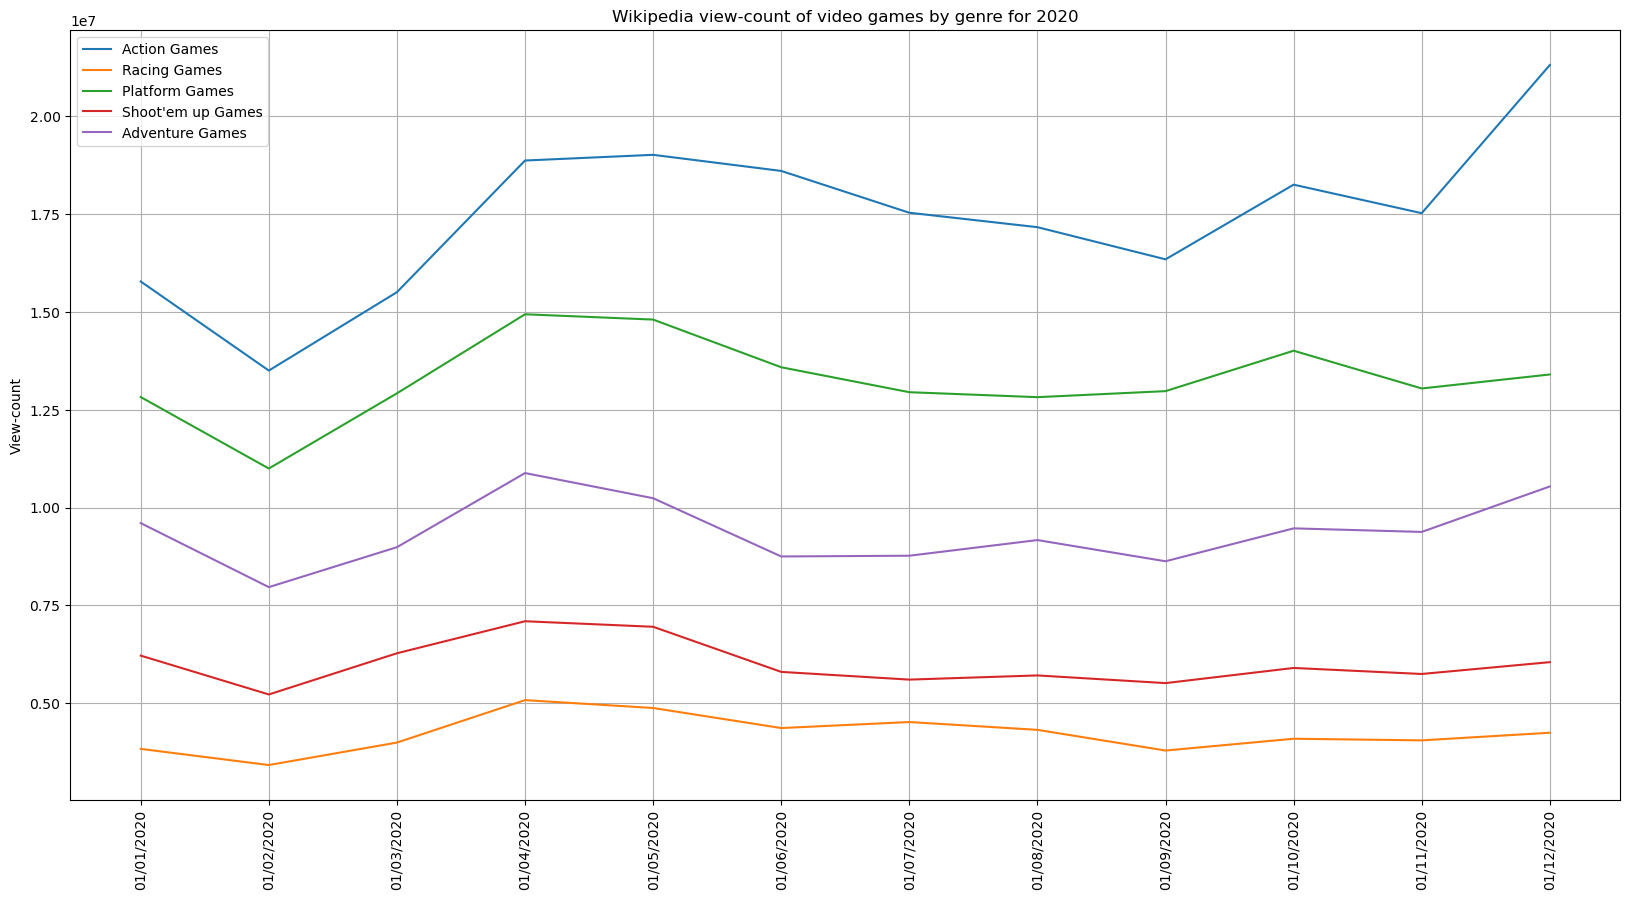

In [126]:
plt.figure(figsize=(20,10))
plt.plot(dates, df.action_game, label="Action Games")
plt.plot(dates, df.racing_video_game, label="Racing Games")
plt.plot(dates, df.platform_game, label="Platform Games")
plt.plot(dates, df['shoot_\'em_up'], label="Shoot'em up Games")
plt.plot(dates, df.adventure_game, label="Adventure Games")
plt.tick_params(axis='x', labelrotation=90)
plt.legend()
plt.grid()
plt.title("Wikipedia view-count of video games by genre for 2020")
plt.ylabel("View-count")
plt.xticks(dates, date)
plt.show()